In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

# Downtown Homelessness Source Package
`sandiegodata.org-downtown_homeless-source-7.1.3` Last Update: 2023-06-19T20:24:33

_Source files for San Diego Downtown homeless sleeper counts_


This dataset provides geographic locations for homeless sleepers in Downtown San Diego, as counted by enumerators from the Downtown San Diego Partnership. These counts have been done monthly since 2012, and this dataset provides counts since 2014. 

This is the source package, use to generate analysis packages. Analysts should probably use one of the analysis packages. See the [Data Library's Homelessness Collection](https://data.sandiegodata.org/collections/homelessness/) for all of the available datasets. 

The count is done on paper maps with handwritten count marks. The San Diego
Regional Data Library's [Downton Homelessness
project](http://downtown-homelessness.sandiegodata.org/) converted these
scanned count maps using a [web based image annotation
tool, VIA](http://www.robots.ox.ac.uk/~vgg/software/via/). These data are extracted from the JSON output from VIA. 

This package has two top level files, and four predecessor files. The top level files are: 

* ``counts``. One record for each handwritten count marking on a map. 
* ``files``. One record for each of the scanned, handmarked maps. 

The predecessor files are: 

* ``raw_file_annotations``. File annotations extracted from the VIA output.
* ``raw_count_annotations``. Count annotations extracted from the VIA output.
* ``raw_gcp``. Ground control point annotations ( street intersections ) extracted from VIA.
* ``gcp_transforms``. Ground control points, in both image and geographic coordinates, with an affine transformation matrix to convert between them. 
* ``intersections``. Geographic positions and names of the street intersections used as ground control points. 

## Caveats

Because this data is extracted, manually, from manually recorded maps, there
are a lot of quality issues. 

### Missing Months

Because of conversion errors and some complications with the source maps, there
are several months of data that are excluded from this dataset

* **August 2014**. In the original datasets, August 2014 was a duplicate of September 2014. 
* **September 2014**. Comfusion related to the duplication of September and August resulted in September being incompletely processed. 
* **June 2015**. All of the map images for this month were blank. An alternate source PDF exists that is not blank, but this file was not used.     


### Not Using Ocupancy Multipliers

Since about 2017, HUD has instructed point-in-time homeless counts to multiply
the counts of sleepers in structures and vehicles by factors to account for
people who may be obsured and not directly countable. From April 2017 on,
Downtown San Diego Partnership has been using these factors.

However, this dataset does not use the occupancy factors, to allow analysts to
apply these factors consistently across all months of data. As a result, the
counts from this dataset diverge from the official counts after March 2017.

### Other Issues 

* The ``total_count`` often does not match the sum of counts on the map. These sums were made by hand, by the enumerator who made the counts, so there are occasional arithmetic errors.  
* There are many instances of missing values for ``rain`` or ``temp``
* Some dates include the day of the month, but many don't These dates have a day of month of 1.
* Date day of month is generally unreliable. Only the year and month are reliable, except for files noted above. 
* The ``neighborhood`` value is based on the map names, so in some months
  the East Village neighborhood is separated into ``east_village`` and ``east_village_south``

### Comparison to Official Published Counts

This plot shows, per month, the offical published counts from San Diego Downtown Partnership versus the total from this dataset. Note the descrepancies dues to issues noted above, including missing months, minor differences in some mont

In [3]:
# Build a dataframe from the source directories, then group by the base file name, so we can c
# combine them. 
from pathlib import Path
from itertools import chain

rows = []
for fn in chain(pkg.reference('source_2019').resolved_url.fspath.glob('*.csv'), 
                pkg.reference('source_2023').resolved_url.fspath.glob('*.csv')):
    rows.append({'fn': fn.name, 'path': fn})
  
datasets = {}
for gn, g in pd.DataFrame(rows).groupby('fn'):
    
    frames = [ pd.read_csv(r.path) for idx, r in g.iterrows() ]
    name = gn.replace('.csv','')
    df = pd.concat(frames)
    datasets[name] = df
    
    locals()[name] = df # The metapack builder expects local vars. 
    
    

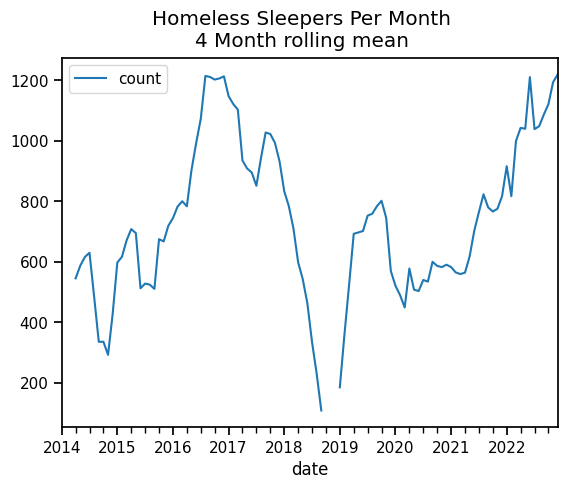

In [4]:
counts['date'] = pd.to_datetime(counts['date'])
t = counts.set_index('date').groupby(pd.Grouper(freq="MS"))['count'].sum().to_frame()
t = t.rolling(4).mean()
t.loc[t['count'] == 0,'count'] = None
t.plot()
plt.suptitle('Homeless Sleepers Per Month\n4 Month rolling mean');